# Grocery Problem: Preprocessing Data 2
In this notebook, we take steps to analyse and explore the grocery data and further prepare the data for later model building

## Imports & notebook setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import gc
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import pandas as pd

from datetime import date

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display # extract a feature record from each date
from sklearn import metrics
from sklearn import preprocessing
from sklearn import decomposition

from multiprocessing import cpu_count, Pool
from multiprocessing.pool import ThreadPool

## Load the data
We restore the preprocessed data from the previous notebook

In [3]:
%time train_df = pd.read_feather("data/groceries/train_pp.feather")
%time test_df = pd.read_feather("data/groceries/test_pp.feather")

CPU times: user 7.07 s, sys: 16 s, total: 23 s
Wall time: 3.51 s
CPU times: user 1.76 s, sys: 6 s, total: 7.76 s
Wall time: 1.01 s


#### Reducing RAM consumption
Currently the dataframes are very RAM heavy:

In [4]:
train_df.info(max_cols=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Columns: 97 entries, index to unit_sales
dtypes: float32(1), float64(95), int64(1)
memory usage: 7.2 GB


In [5]:
test_df.info(max_cols=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3370464 entries, 0 to 3370463
Columns: 96 entries, index to locale_Regional
dtypes: float64(95), int64(1)
memory usage: 2.4 GB


Since the data takes a large amount of ram, we reducefit my converting the  value from float64 to float32. This should half our RAM consumption

In [6]:
# Converts the floats in the df dataframe float64 to float32 inplace
# returns the converted dataframe
def downcast_float32(df):
    for col_name in df.columns:
        # find columns with float64 datatype
        if df[col_name].dtype == 'float64':
            # convert column to float32 inplace
            df[col_name]= df[col_name].astype('float32', copy=False)
    return df

In [7]:
%time train_df = downcast_float32(train_df)
%time test_df = downcast_float32(test_df)

CPU times: user 4min 5s, sys: 4min 18s, total: 8min 23s
Wall time: 1min 35s
CPU times: user 1min 26s, sys: 1min 25s, total: 2min 52s
Wall time: 31.6 s


Now the data fit confortablely into ram:

In [8]:
train_df.info(max_cols=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Columns: 97 entries, index to unit_sales
dtypes: float32(96), int64(1)
memory usage: 3.7 GB


In [9]:
test_df.info(max_cols=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3370464 entries, 0 to 3370463
Columns: 96 entries, index to locale_Regional
dtypes: float32(95), int64(1)
memory usage: 1.2 GB


## Exploring the data
In this section, we explore the data using data exploratory techniques

1. We first use `df.describe()` to obtain a statisical summary of data

In [10]:
train_df.describe()

,index,id,date,store_nbr,item_nbr,onpromotion,class,perishable,cluster,dcoilwtico,...,type_y_Additional,type_y_Bridge,type_y_Event,type_y_Holiday,type_y_Transfer,type_y_Work Day,locale_Local,locale_National,locale_Regional,unit_sales
count,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,10000000.0,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,...,1.000000e+07,10000000.0,1.000000e+07,1.000000e+07,1.000000e+07,10000000.0,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07
mean,1.204970e+08,-4.783203e-07,-4.044922e-07,-4.315186e-09,-8.056640e-10,0.0,-5.325317e-10,-1.313324e-08,-5.569458e-09,-3.181518e-07,...,7.267578e-07,0.0,2.260474e-06,1.766699e-06,-2.043115e-06,0.0,-9.697266e-07,-1.236182e-06,8.707764e-07,8.104366e+00
std,2.886751e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,0.0,1.000000e+00,1.000000e+00,1.000000e+00,0.0,1.000000e+00,1.000000e+00,1.000000e+00,2.466237e+01
min,1.154970e+08,-1.747133e+00,-8.337458e-01,-1.670422e+00,-1.828894e+00,0.0,-8.078153e-01,-5.866986e-01,-1.689316e+00,-2.046201e+00,...,-3.916546e-01,0.0,-3.447308e-01,-8.532497e-01,-7.169128e-01,0.0,-8.713695e-01,-9.657815e-01,-3.063821e-01,-9.300000e+02
25%,1.179970e+08,-8.658916e-01,-8.337458e-01,-9.349593e-01,-8.139869e-01,0.0,-7.610148e-01,-5.866986e-01,-8.128005e-01,-7.130504e-01,...,-3.916546e-01,0.0,-3.447308e-01,-8.532497e-01,-7.169128e-01,0.0,-8.713695e-01,-9.657815e-01,-3.063821e-01,2.000000e+00
50%,1.204970e+08,5.353633e-05,-8.337458e-01,4.565822e-02,6.927008e-02,0.0,-6.506993e-01,-5.866986e-01,6.371449e-02,6.850359e-03,...,-3.916546e-01,0.0,-3.447308e-01,-8.532497e-01,-7.169128e-01,0.0,-8.713695e-01,-9.657815e-01,-3.063821e-01,4.000000e+00
75%,1.229970e+08,8.659987e-01,1.198116e+00,9.649871e-01,6.946353e-01,0.0,6.145852e-01,1.704453e+00,9.402295e-01,8.822864e-01,...,-3.916546e-01,0.0,-3.447308e-01,1.171990e+00,1.394870e+00,0.0,1.147619e+00,1.035431e+00,-3.063821e-01,8.000000e+00
max,1.254970e+08,1.731944e+00,3.229978e+00,1.577873e+00,1.634225e+00,0.0,4.856715e+00,1.704453e+00,1.816745e+00,1.793272e+00,...,2.553270e+00,0.0,2.900814e+00,1.171990e+00,1.394870e+00,0.0,1.147619e+00,1.035431e+00,3.263898e+00,1.537500e+04


2. We seperate the training data in training inputs and outputs

In [11]:
train_outs = train_df.unit_sales
train_df.drop(columns="unit_sales", inplace=True)
train_ins = train_df

Test data contains only inputs so we just assign the test dataframe as inputs

In [12]:
test_ins = test_df

Notice that are a large number of input features in the dataset

In [13]:
n_features = train_ins.shape[-1]
print(f"there are {n_features} input features")

there are 96 input features


## Preparing the data
There are a large number of input features in this dataset, making visualisation and training a model to fit the data difficult


### Dimentionality Reduction using PCA
Hence we apply PCA to reduce no. of features in our inputs.

> We have already done the feature scaling required before applying PCA in the previous notebook

To measure how well a PCA decomposition captures the variance in the data/ how much infomation is lost in the dimention reduction process we create an error function:

In [14]:
# Measures and returns the mean variance error
def mean_variance_error(X, X_approx):
    # Check no of features are valid (equal)
    assert len(X) == len(X_approx)
    n_features = len(X)
    
    # Average squared projection error  1/m * sum(|| X - X_approx ||2)
    mean_sq_projection_error = np.sum(
        np.linalg.norm(X - X_approx, ord=2)) / n_features
    # total varation in data 1/m * sum(|| X - X_approx||2)
    total_variation = np.sum(
        np.linalg.norm(X, ord=2)) / n_features
    
    return mean_sq_projection_error / total_variation


We try different no. of precipal components to try to decide how many principal components to use.

In [1]:
sample_train_ins = train_ins.head(10000) # head because its time series

n_components = np.random.randint(1, 96, size=80)
errors = []

for n_component in n_components:
    pca = decomposition.PCA(n_components=n_component)
    pca.fit(sample_train_ins)
                    
    train_pca_ins = pca.transform(sample_train_ins)
    train_approx_ins = pca.inverse_transform(train_pca_ins)

    errors.append(mean_variance_error(train_approx_ins, sample_train_ins))

NameError: name 'train_ins' is not defined

Plot the trend of principal components to loss.

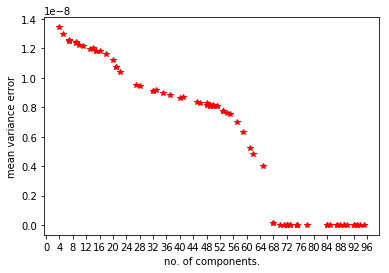

In [16]:
fig, ax = plt.subplots(1,1)
plt.xlabel("no. of components.")
plt.ylabel("mean variance error")
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=4))
plt.plot(n_components, errors, "r*")

From the analysis of this graph, we can see the optimal no. of components see to be around ~68 components.
With this choice this no. of components, we try to compress the entire dataset.

Instead of using normal PCA, we use incremental PCA to ensure that the procedure fits into ram

In [17]:
pca = decomposition.IncrementalPCA(n_components=68, batch_size=68 * 2)
%time pca.fit(train_ins)
%time train_ins = pca.transform(train_ins)
%time test_ins = pca.transform(test_ins)

CPU times: user 23min 44s, sys: 2min 54s, total: 26min 38s
Wall time: 5min 34s
CPU times: user 50.7 s, sys: 38.5 s, total: 1min 29s
Wall time: 45.6 s
CPU times: user 7.73 s, sys: 6.07 s, total: 13.8 s
Wall time: 13.3 s


In [18]:
n_features = train_ins.shape[-1]
print(f"there are {n_features} input features")

there are 68 input features


### Casting floats 
We further reduce the size of data by casting the dataset from `float64` to `float32`

In [23]:
train_ins = train_ins.astype("float32", copy=False)
test_ins =  test_ins.astype("float32", copy=False)

## Commit data to disk
The data is ready for building models.
We commit them to disk using `numpy.savez()`

In [27]:
# Convert training output to numpy array
train_outs = train_outs.values

In [29]:
with open("data/groceries/groceries_dataset.npz", "wb") as f:
    np.savez(f, train_ins=train_ins, 
        train_outs=train_outs,
        test_ins=test_ins)

Save the PCA object for future use

In [ ]:
with open("data/groceries/pca.pickle", "wb") as